# ANVISA Twitter Analysis

In [1]:
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import json
import re
!pip install unidecode
import unidecode
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.2 MB/s 


In [2]:
entity = 'anvisa'
agency_twitter = 'anvisa_oficial'

In [3]:
# setup security 
access_token = '1006599768104144896-08Q8MuqehWAXLYxH4qfQPd3ihda2WW'
access_token_secret = 'hZGfKdUzY1t2jUrA5t2egNhoKTPCz457orKvFVVDD117G'
consumer_key = 'mVDo4ha0iWDHYXdalHH6g8tx7'
consumer_secret = 'A6vRmL8VmLwpncQD2at0PHkzBswjT7m70BWmpv0rMkxBbvIoan'

In [4]:
# setup file store
from google.colab import drive
drive.mount('/content/drive/')
path_drive = '/content/drive/My Drive/[UFU] Pesquisa/MobiSocial 2022/'
file = path_drive + entity + '/' + entity + '_tweets.json'
edges_file = path_drive + entity + '/' + entity + '_hashtags.csv'

Mounted at /content/drive/


# Getting tweets

In [ ]:
import tweepy #https://github.com/tweepy/tweepy
import csv

def get_all_tweets(screen_name, filew):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    alltweets = []

    new_tweets = api.user_timeline(screen_name = screen_name,count=200,tweet_mode='extended')

    for tweet in new_tweets:
        json_str = json.dumps(tweet._json)
        filew.write(json_str + '\n')
    
    alltweets.extend(new_tweets)

    oldest = alltweets[-1].id - 1

    while len(new_tweets) > 0:
        print ("getting tweets before %s" % (oldest))

        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest,tweet_mode='extended')

        for tweet in new_tweets:
            json_str = json.dumps(tweet._json)
            filew.write(json_str + '\n')
        
        alltweets.extend(new_tweets)

        oldest = alltweets[-1].id - 1

        print ("...%s tweets downloaded so far" % (len(alltweets)))
        
filew = open(file, 'w')
get_all_tweets(agency_twitter, filew)
filew.close()


getting tweets before 1472935420908425216
...400 tweets downloaded so far
getting tweets before 1453798521220603905
...600 tweets downloaded so far
getting tweets before 1423652799112437768
...800 tweets downloaded so far
getting tweets before 1392873081052573699
...1000 tweets downloaded so far
getting tweets before 1362080299857895426
...1200 tweets downloaded so far
getting tweets before 1319704261656281087
...1400 tweets downloaded so far
getting tweets before 1270434723500867586
...1600 tweets downloaded so far
getting tweets before 1250449669253140479
...1800 tweets downloaded so far
getting tweets before 1234876494779953152
...2000 tweets downloaded so far
getting tweets before 1203051682944495615
...2200 tweets downloaded so far
getting tweets before 1177659688080564229
...2400 tweets downloaded so far
getting tweets before 1138451354131869696
...2600 tweets downloaded so far
getting tweets before 1126562572122116095
...2800 tweets downloaded so far
getting tweets before 111101

## Hashtags network

In [ ]:
with open(file, 'r') as f:
    alltweets = f.readlines()

texts = []
for tweet_line in alltweets:   
    tweet = json.loads(tweet_line)
    texts.append(tweet['full_text'])

print(len(texts))

3250


In [ ]:
## get hashtags
def extract_hash_tags(s):
    return set(part[1:] for part in s.split() if part.startswith('#'))

def normalize_text(s):
    s = re.sub(r'[^\w\s]','',s)
    s = s.lower()
    s = unidecode.unidecode(s)
    return s

allhashtags = set()
hashtagsList = []
for i, text in enumerate(texts):
    wordList = extract_hash_tags(text)
    if wordList:
        hashtags = [normalize_text(w) for w in wordList]
        for w in hashtags:
            allhashtags.add(w)
        print(i, wordList, hashtags)
        hashtagsList.append(hashtags)

print('\n### Tamanho total do conjunto de hashtags:', len(allhashtags))
print('\n### Quantidade de listas de hashtags:', len(hashtagsList))

21 {'regulacaosanitaria', 'transparencia', 'anvisa'} ['regulacaosanitaria', 'transparencia', 'anvisa']
43 {'covid19', 'coleta', 'autotestescovid19', 'regulacaosanitaria', 'anvisa', 'autoteste'} ['covid19', 'coleta', 'autotestescovid19', 'regulacaosanitaria', 'anvisa', 'autoteste']
103 {'anvisa', 'sus'} ['anvisa', 'sus']
105 {'anvisa', 'doacaodesangue'} ['anvisa', 'doacaodesangue']
106 {'transparencia', 'anvisa'} ['transparencia', 'anvisa']
137 {'farmacêuticos', 'farmacêuticas'} ['farmaceuticos', 'farmaceuticas']
175 {'anvisa', 'peticionamento'} ['anvisa', 'peticionamento']
176 {'anvisa', 'cannabis'} ['anvisa', 'cannabis']
177 {'vacina', 'covid19', 'anvisa', 'coronavirus'} ['vacina', 'covid19', 'anvisa', 'coronavirus']
179 {'dispositivosmedicos', 'anvisa'} ['dispositivosmedicos', 'anvisa']
183 {'cbpf', 'transparencia', 'anvisa'} ['cbpf', 'transparencia', 'anvisa']
184 {'transparencia', 'anvisa'} ['transparencia', 'anvisa']
185 {'anvisa', 'dcb'} ['anvisa', 'dcb']
187 {'dispositivosmedico

In [ ]:
## normalizing hashtaghs
def normalize(hashtag):
    if hashtag == 'plástico': return 'plastico'
    return hashtag
  

for hashtags in hashtagsList:
    for i in range(len(hashtags)):
        hashtags[i] = normalize(hashtags[i])

In [ ]:
## building the network
edges = {}
for hashtags in hashtagsList:
    for i in range(len(hashtags)):
        for j in range(i+1, len(hashtags)):
            key = hashtags[i] + '-' + hashtags[j]
            edge = (hashtags[i], hashtags[j], 1)
            if key in edges:
                (h1, h2, w) = edges[key]
                edge = (h1, h2, w+1)
                edges.update( {key : edge} )
            else:
                edges.update( {key : edge} )
            print(edge)

('regulacaosanitaria', 'transparencia', 1)
('regulacaosanitaria', 'anvisa', 1)
('transparencia', 'anvisa', 1)
('covid19', 'coleta', 1)
('covid19', 'autotestescovid19', 1)
('covid19', 'regulacaosanitaria', 1)
('covid19', 'anvisa', 1)
('covid19', 'autoteste', 1)
('coleta', 'autotestescovid19', 1)
('coleta', 'regulacaosanitaria', 1)
('coleta', 'anvisa', 1)
('coleta', 'autoteste', 1)
('autotestescovid19', 'regulacaosanitaria', 1)
('autotestescovid19', 'anvisa', 1)
('autotestescovid19', 'autoteste', 1)
('regulacaosanitaria', 'anvisa', 2)
('regulacaosanitaria', 'autoteste', 1)
('anvisa', 'autoteste', 1)
('anvisa', 'sus', 1)
('anvisa', 'doacaodesangue', 1)
('transparencia', 'anvisa', 2)
('farmaceuticos', 'farmaceuticas', 1)
('anvisa', 'peticionamento', 1)
('anvisa', 'cannabis', 1)
('vacina', 'covid19', 1)
('vacina', 'anvisa', 1)
('vacina', 'coronavirus', 1)
('covid19', 'anvisa', 2)
('covid19', 'coronavirus', 1)
('anvisa', 'coronavirus', 1)
('dispositivosmedicos', 'anvisa', 1)
('cbpf', 'transp

In [ ]:
## generating edges file
filew = open(edges_file, 'w')
filew.write('Source,Target,weight\n')
print('Source,Target,weight')
for key, edge in edges.items():
    (h1,h2,w) = edge
    if h1 and h2:
        edgeLine = h1 + ',' + h2 + ',' + str(w)
        print(edgeLine)
        filew.write(edgeLine + '\n')
        
filew.close()    

Source,Target,weight
regulacaosanitaria,transparencia,1
regulacaosanitaria,anvisa,2
transparencia,anvisa,7
covid19,coleta,1
covid19,autotestescovid19,1
covid19,regulacaosanitaria,1
covid19,anvisa,92
covid19,autoteste,1
coleta,autotestescovid19,1
coleta,regulacaosanitaria,1
coleta,anvisa,1
coleta,autoteste,1
autotestescovid19,regulacaosanitaria,1
autotestescovid19,anvisa,1
autotestescovid19,autoteste,1
regulacaosanitaria,autoteste,1
anvisa,autoteste,1
anvisa,sus,8
anvisa,doacaodesangue,2
farmaceuticos,farmaceuticas,1
anvisa,peticionamento,5
anvisa,cannabis,2
vacina,covid19,28
vacina,anvisa,37
vacina,coronavirus,30
covid19,coronavirus,72
anvisa,coronavirus,97
dispositivosmedicos,anvisa,6
cbpf,transparencia,1
cbpf,anvisa,1
anvisa,dcb,4
dispositivosmedicos,rdc579,1
anvisa,rdc579,1
sus,inca,1
sus,anvisa,7
sus,doacaodemedula,1
sus,transplantedemedula,1
sus,redome,1
inca,anvisa,1
inca,doacaodemedula,1
inca,transplantedemedula,1
inca,redome,1
anvisa,doacaodemedula,1
anvisa,transplantedemedula,

# Engagement analysis

In [5]:
with open(file, 'r') as f:
    alltweets = f.readlines()

texts = []
for tweet_line in alltweets:   
    tweet = json.loads(tweet_line)
    engaged = tweet['retweet_count'] + tweet['favorite_count'] + len(tweet['entities']['user_mentions'])
    texts.append([tweet['id_str'],tweet['created_at'],tweet['retweet_count'],tweet['favorite_count'],len(tweet['entities']['user_mentions']),tweet['is_quote_status'],engaged,tweet['full_text']])

columns = ['id','created_at','rt_count','fav_count','mentions_count','is_quote','engaged','text']
df = pd.DataFrame(texts, columns=columns)
total_tweets = len(df)
print('Total tweets: ', total_tweets)

df.head()

Total tweets:  3250


,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text
0,1509595098346045444,Thu Mar 31 18:14:53 +0000 2022,2,21,0,False,23,A Anvisa aprovou a autorização temporária de uso emergencial do medicamento Paxlovid para tratamento da Covid-19. O medicamento é indicado para pacientes adultos que não requerem oxigênio suplementar e apresentam risco de progressão para Covid-19 grave. \nhttps://t.co/6wPsNgXOBc https://t.co/PRX404Fbf4
1,1509588022689468433,Thu Mar 31 17:46:46 +0000 2022,2,20,0,False,22,"Neste Dia da Saúde e da Nutrição é importante pararmos para refletir sobre os hábitos alimentares e a prática regular de atividades físicas. Vale lembrar que para se ter uma boa nutrição é preciso manter uma dieta equilibrada, com quantidade e variedade adequadas de nutrientes. https://t.co/eusIPkqCZL"
2,1509569737826701316,Thu Mar 31 16:34:06 +0000 2022,4,15,0,False,19,"Foram aprovados mais cinco autotestes para Covid-19. Até o momento, a Anvisa já autorizou 17 autotestes. A lista completa dos autotestes registrados, atualizada periodicamente, está disponível em nosso portal, num painel eletrônico (https://t.co/456vIxf86p). https://t.co/nEfNL88a4F"
3,1509511851092197387,Thu Mar 31 12:44:05 +0000 2022,1,5,0,False,6,"A nutrivigilância trata da vigilância de eventos adversos decorrentes do consumo de alimentos industrializados e do monitoramento da segurança desses produtos. \nPara relatar um evento adverso ou queixa técnica, acesse o Notivisa (https://t.co/KbnVcZKxfN). https://t.co/kVHXMUodie"
4,1509199426916605953,Wed Mar 30 16:02:37 +0000 2022,5,19,0,False,24,"Cosmetovigilância é o monitoramento de eventos adversos após o uso de perfumes, produtos de higiene pessoal e de embelezamento notificados pelos usuários. O objetivo é acompanhar os relatos desses casos e gerar alertas a fim de evitar que outras pessoas sejam afetadas. https://t.co/TtQDAlEDb8"


In [6]:
## counting number of engaged tweets
def engaged_tweets(df):
    #return df[(df.rt_count > 0) | (df.fav_count > 0)].count()
    return df[(df.engaged > 0)].count()

def not_engaged_tweets(df):
    return df[(df.engaged == 0)].count()

def engaged_rt_tweets(df):
    return df[(df.rt_count > 0)].count()

def engaged_fav_tweets(df):
    return df[(df.fav_count > 0)].count()

def engaged_mention_tweets(df):
    return df[(df.mentions_count > 0)].count()

sum_engaged_tweets = engaged_tweets(df)
print('Engaged tweets: ', sum_engaged_tweets['rt_count'], sum_engaged_tweets['rt_count']*100/total_tweets)
sum_engaged_rt_tweets = engaged_rt_tweets(df)
print('Engaged rt tweets: ', sum_engaged_rt_tweets['rt_count'], sum_engaged_rt_tweets['rt_count']*100/sum_engaged_tweets['rt_count'])
sum_engaged_fav_tweets = engaged_fav_tweets(df)
print('Engaged fav tweets: ', sum_engaged_fav_tweets['fav_count'], sum_engaged_fav_tweets['fav_count']*100/sum_engaged_tweets['fav_count'])
sum_engaged_mention_tweets = engaged_mention_tweets(df)
print('Engaged mention tweets: ', sum_engaged_mention_tweets['mentions_count'], sum_engaged_mention_tweets['mentions_count']*100/sum_engaged_tweets['mentions_count'])
sum_not_engaged_tweets = not_engaged_tweets(df)
print('Not Engaged tweets: ', sum_not_engaged_tweets['rt_count'], sum_not_engaged_tweets['rt_count']*100/total_tweets)

Engaged tweets:  3206 98.64615384615385
Engaged rt tweets:  2477 77.26138490330631
Engaged fav tweets:  3025 94.35433562071117
Engaged mention tweets:  514 16.03243917654398
Not Engaged tweets:  44 1.353846153846154


In [7]:
## getting most engaged tweets

df = df.sort_values(by=['engaged'],ascending=False)
df.head(10)

,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text
1722,1240795011630981120,Fri Mar 20 00:19:18 +0000 2020,3600,7031,0,False,10631,"Diante das notícias sobre uso de medicamentos que contêm hidroxicloroquina e cloroquina para tratar a Covid-19, a Anvisa esclarece que não há estudos conclusivos que comprovam o uso desses medicamentos para o tratamento do novo coronavírus. Leia a matéria: https://t.co/RduV5WdeNA https://t.co/yOVxhlXgxr"
625,1420520305999679492,Wed Jul 28 23:03:27 +0000 2021,4669,0,1,False,4670,"RT @Rayssa_Leal_Sk8: Recadinho para a galerinha de Imperatriz 👇\n\nTô cheganuuu! Só vai rolar 👋🏽 de longe, sem aglomeração 😷\n\nSe cuidem! Usem…"
1051,1353775569691938816,Mon Jan 25 18:43:42 +0000 2021,612,3308,0,False,3920,"Confira a tabela com as características das vacinas autorizadas para uso emergencial (CoronaVac, do Instituto Butantan, e Covishield, da Fiocruz) e também as respectivas bulas para profissionais de saúde e pacientes.\n\nhttps://t.co/eoYY4PbLgp\n#anvisa #coronavirus #covid19 #vacina https://t.co/0qHsxAENcL"
936,1371575427681116163,Mon Mar 15 21:33:59 +0000 2021,341,2014,0,False,2355,"O lote da vacina de Oxford que teve o uso suspenso pelas autoridades europeias não veio para o Brasil. Nas bases de dados nacionais, que reúnem os eventos adversos ocorridos com vacinas, não há registros de embolia ou trombose associados às vacinas.\nhttps://t.co/AuZZb6V0aq https://t.co/1TKhKrCywu"
337,1464289732507090947,Fri Nov 26 17:47:32 +0000 2021,411,1636,0,False,2047,"A Anvisa recomenda medidas restritivas para voos e viajantes procedentes da África do Sul, Botsuana, Eswatini, Lesoto, Namíbia e Zimbábue, em decorrência de nova variante do SARS-CoV-2. Confira a Nota Técnica 203/2021 com orientação ao governo brasileiro. https://t.co/U0Gq2aA0at https://t.co/xUpGhaNFv4"
1113,1337726691003797505,Sat Dec 12 11:51:11 +0000 2020,532,1165,0,False,1697,Você já conferiu como está a apresentação de documentos das empresas que estão desenvolvendo vacinas contra a Covid 19 no Brasil? O quadro foi atualizado (12/12/2020) com o pedido de duas empresas à Anvisa da CBPF. Fique por dentro da análise das vacinas https://t.co/SQa9VlWatR https://t.co/UYgsoW2R7Q
209,1471510284590358532,Thu Dec 16 15:59:25 +0000 2021,237,1241,0,False,1478,"A Anvisa autorizou hoje o pedido da Pfizer para utilização de sua vacina contra Covid-19 em crianças de 5 a 11 anos. O pedido foi avaliado em 21 dias, descontados os 14 dias que o laboratório utilizou para responder as exigências técnicas. \nAcesse https://t.co/dKkQzDEYxC https://t.co/BsF6FtFDIQ"
1588,1251619355709845504,Sat Apr 18 21:11:23 +0000 2020,1451,0,1,False,1452,RT @minsaude: Mande um “oi” no nosso número no WhatsApp: (61) 9938-0031 e faça o diagnóstico do #coronavirus sem sair de casa. Tele-SUS. Co…
836,1386873899753820161,Tue Apr 27 02:44:39 +0000 2021,219,662,0,False,881,"A Diretoria Colegiada da Anvisa, reunida nesta segunda, decidiu não autorizar a importação da vacina Sputnik V. Técnicos da Agência apresentaram análises que apontam inconsistências nos dados disponíveis até o momento sobre o imunizante. Leia mais em: https://t.co/oSlAS3XSny https://t.co/wIagy8EkPV"
1061,1350785536638808065,Sun Jan 17 12:42:22 +0000 2021,167,666,0,False,833,Acompanhe ao vivo a Reunião Extraordinária da Diretoria Colegiada da Anvisa.\nhttps://t.co/kEJHFRbmn8


In [8]:
## getting collect period
pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y").sort_values()

3249   2019-02-01 10:57:36
3248   2019-02-01 11:05:38
3247   2019-02-01 12:00:17
3246   2019-02-01 17:02:45
3245   2019-02-01 18:38:08
               ...        
4      2022-03-30 16:02:37
3      2022-03-31 12:44:05
2      2022-03-31 16:34:06
1      2022-03-31 17:46:46
0      2022-03-31 18:14:53
Name: created_at, Length: 3250, dtype: datetime64[ns]

In [9]:
## most mentioned users
with open(file, 'r') as f:
    alltweets = f.readlines()

mentions = {}
for tweet_line in alltweets:   
    tweet = json.loads(tweet_line)
    user_mentions = tweet['entities']['user_mentions']
    for user in user_mentions:
        key = user['screen_name']
        if key in mentions:
            count = mentions[key]
            mentions.update( {key : count+1} )
        else:
            mentions.update( {key : 1} )
        
for w in sorted(mentions, key=mentions.get, reverse=True):
    print(w, mentions[w])


anvisa_oficial 43
minsaude 22
secsaudedf 20
YouTube 19
ConassOficial 19
makibmtlk 18
ebcnarede 14
Medicina_CFM 14
saudeprefsp 13
SaudeMG 12
ElzaSoares 10
PrefManaus 10
MinEconomia 9
comunicacns 9
imprensacff 9
DigitalGovBr 8
SesapRN 8
agencia_fiocruz 8
CanalSaude 8
visa_rio 8
VisaGoiania 7
Cofen_oficial 7
faustdcjr 6
butantanoficial 6
LeoHistor 6
soninhaz 6
Visa_Arapiraca 6
Saude_Recife 6
PrefSalvador 6
BiancaThi1 5
anvisa 5
visatimbo 5
RevistaSaude 5
RadioagenciaEBC 5
SemsaManaus 5
Curitiba_PMC 5
governosp 5
marcelams1511 4
fe_passos 4
AlexandreLit 4
Suzanne47510225 4
oAlienigina 4
priveneza 4
Didi70282640 4
LineLemos21 4
RenataMaC2 4
_deinha13 4
leticiabanffy 4
CNI_br 4
lourdinha_paiva 4
carol_caqqe 4
Mi_Rikaz 4
RobertaRosas 4
LeonardoNascim1 4
OuvidoriaAnvisa 4
tizdias 4
visatx 4
tvcamara 4
FNN_Brasil 4
RegianeSBraga 4
prefeitura_CBA 4
ABRASCO 4
SESAI_MS 4
sesoficial 4
governosergipe 4
GovernoES 4
saudegoias 4
Fabifecchio 4
MTurismo 4
economiagovbr 4
Gabiacansada 3
silmagyar 3
van_b

# Temporal Analysis

In [10]:
total = len(df)
print('Total number of tweets: ', total)

Total number of tweets:  3250


Text(0.5, 1.0, 'anvisa tweets distribution per month')

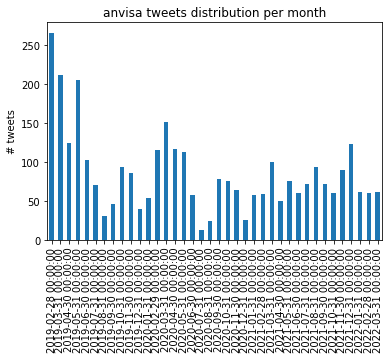

In [11]:
## temporal analysis
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="M"))
g['id'].count().plot(kind="bar")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' tweets distribution per month')

Text(0.5, 1.0, 'anvisa tweets distribution per week')

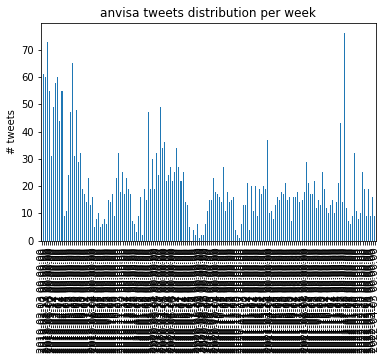

In [12]:
## temporal analysis
import numpy
%matplotlib inline

df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="W"))
g['id'].count().plot(kind="bar")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' tweets distribution per week')

Text(0.5, 1.0, 'anvisa number of tweets per day')

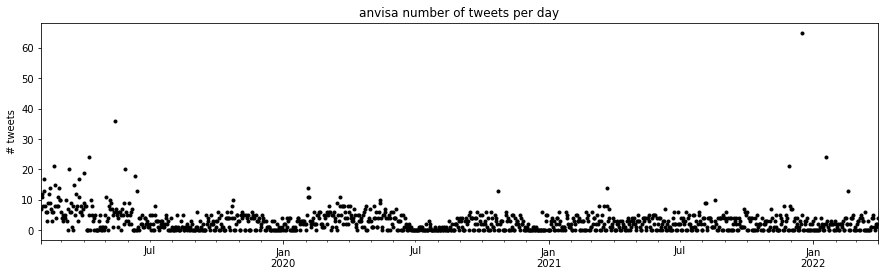

In [13]:
## temporal analysis
import numpy
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
g['id'].count().plot(style="k.")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' number of tweets per day')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Figure size 1080x288 with 0 Axes>

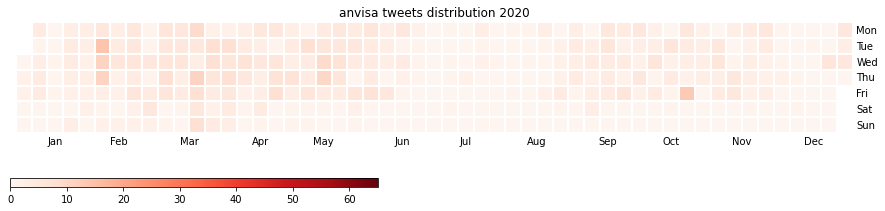

In [14]:
## temporal analysis
import numpy
!pip install calmap
import calmap
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
quantities = g['id'].count()

year = 2020
fig = plt.figure(figsize=(15,6))
plt.title(entity + ' tweets distribution ' + str(year))
#ax = fig.add_subplot(111)
cax = calmap.yearplot(quantities, year=year)
#fig.colorbar(cax.get_children()[1], ax=cax, orientation='vertical', aspect=2)

cbar_ax = fig.add_axes([0.12, 0.25, 0.34, 0.02])
fig.colorbar(cax.get_children()[1], cax=cbar_ax, orientation="horizontal")

<Figure size 1080x288 with 0 Axes>

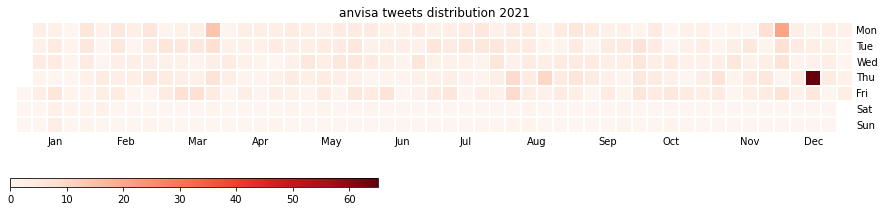

In [15]:
## temporal analysis
import numpy
#!pip install calmap
import calmap
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
quantities = g['id'].count()

year = 2021
fig = plt.figure(figsize=(15,6))
plt.title(entity + ' tweets distribution ' + str(year))
#ax = fig.add_subplot(111)
cax = calmap.yearplot(quantities, year=year)
#fig.colorbar(cax.get_children()[1], ax=cax, orientation='vertical', aspect=2)

cbar_ax = fig.add_axes([0.12, 0.25, 0.34, 0.02])
fig.colorbar(cax.get_children()[1], cax=cbar_ax, orientation="horizontal")

<Figure size 1080x288 with 0 Axes>

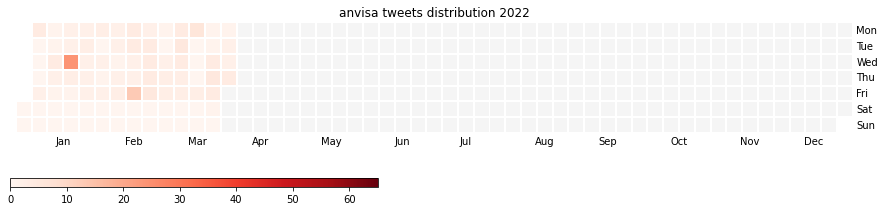

In [16]:
## temporal analysis
import numpy
#!pip install calmap
import calmap
%matplotlib inline
plt.figure(figsize=(15,4))
df['date'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S +0000 %Y")

g = df.groupby(pd.Grouper(key='date',freq="D"))
quantities = g['id'].count()

year = 2022
fig = plt.figure(figsize=(15,6))
plt.title(entity + ' tweets distribution ' + str(year))
#ax = fig.add_subplot(111)
cax = calmap.yearplot(quantities, year=year)
#fig.colorbar(cax.get_children()[1], ax=cax, orientation='vertical', aspect=2)

cbar_ax = fig.add_axes([0.12, 0.25, 0.34, 0.02])
fig.colorbar(cax.get_children()[1], cax=cbar_ax, orientation="horizontal")

Text(0.5, 1.0, 'anvisa tweets distribution per hour')

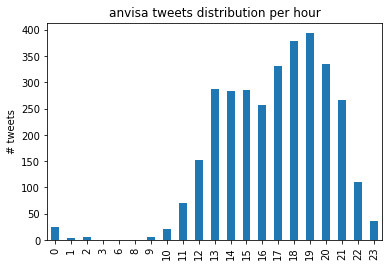

In [17]:
df.groupby(df['date'].dt.hour)['id'].count().plot(kind="bar")
plt.ylabel('# tweets')
plt.xlabel('')
plt.title(entity + ' tweets distribution per hour')

# Trending analysis

In [18]:
import datetime
baseline_str = '2019-02-01'
baseline_date = datetime.datetime.strptime(baseline_str, '%Y-%m-%d')
baseline_date = baseline_date.date()
df['just_date'] = df['date'].apply(datetime.datetime.date)
baseline = df[df['just_date'] == baseline_date]
baseline_count = 0
if len(baseline) > 0:
    baseline_count = baseline.groupby('just_date').count()['id'][0]
print(baseline_count)

7


In [19]:
import math

def change_function(count):
    if math.isnan(count):
        count = 0
    if count == baseline_count:
        return 0
    change = 100*(count-baseline_count)/baseline_count
    return change

df_grouped = df.groupby('just_date', as_index=False).count()
df_grouped['change'] = df_grouped['date'].apply(change_function)
df_grouped.head(5)

,just_date,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text,date,change
0,2019-02-01,7,7,7,7,7,7,7,7,7,0.000000
1,2019-02-02,11,11,11,11,11,11,11,11,11,57.142857
2,2019-02-03,12,12,12,12,12,12,12,12,12,71.428571
3,2019-02-04,8,8,8,8,8,8,8,8,8,14.285714
4,2019-02-05,17,17,17,17,17,17,17,17,17,142.857143


In [20]:
import datetime as dt
# generate pandas with reference_date from 2020-01-01 to 2022-02-01
start = datetime.datetime.strptime("01-02-2019", "%d-%m-%Y")
end = datetime.datetime.strptime("01-02-2022", "%d-%m-%Y")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

agencies_df = pd.DataFrame()
agencies_df['date_created'] = date_generated
agencies_df['date_created'] = agencies_df['date_created'].map(lambda x: x.date())
print(len(agencies_df))
agencies_df.head()

1096


,date_created
0,2019-02-01
1,2019-02-02
2,2019-02-03
3,2019-02-04
4,2019-02-05


In [21]:
agencies_df = pd.merge(agencies_df, df_grouped, how='left', left_on='date_created', right_on='just_date')
agencies_df['change'] = agencies_df['date'].apply(change_function)
agencies_df = agencies_df.sort_values(by='date_created')
agencies_df['order'] = range(1, 1+len(agencies_df))
agencies_df.head()

,date_created,just_date,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text,date,change,order
0,2019-02-01,2019-02-01,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,0.000000,1
1,2019-02-02,2019-02-02,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,57.142857,2
2,2019-02-03,2019-02-03,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,71.428571,3
3,2019-02-04,2019-02-04,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,14.285714,4
4,2019-02-05,2019-02-05,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,142.857143,5


In [22]:
agencies_df.tail(42)

,date_created,just_date,id,created_at,rt_count,fav_count,mentions_count,is_quote,engaged,text,date,change,order
1054,2021-12-21,2021-12-21,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-71.428571,1055
1055,2021-12-22,2021-12-22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-57.142857,1056
1056,2021-12-23,2021-12-23,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,-42.857143,1057
1057,2021-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.000000,1058
1058,2021-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.000000,1059
1059,2021-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.000000,1060
1060,2021-12-27,2021-12-27,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-71.428571,1061
1061,2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.000000,1062
1062,2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.000000,1063
1063,2021-12-30,2021-12-30,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-71.428571,1064


<Figure size 1080x720 with 0 Axes>

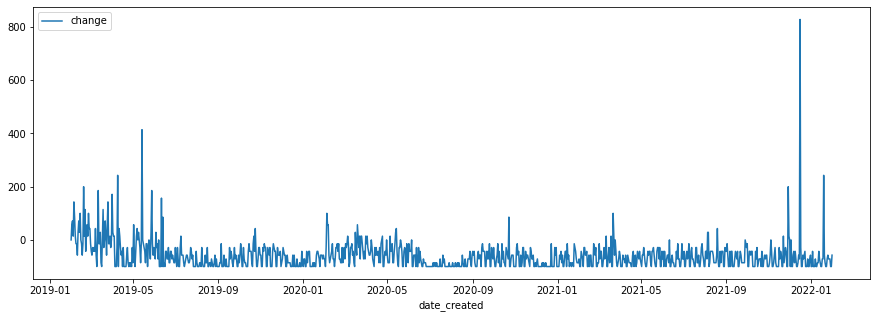

In [23]:
plt.figure(figsize=(15,10))
agencies_df.plot(kind='line', x='date_created', y='change',figsize=(15, 5))
plt.show()

In [27]:
mark_firstcase = agencies_df[agencies_df['date_created']==datetime.date(2020,2,26)]['order'].to_list()[0]
mark_firstmh = agencies_df[agencies_df['date_created']==datetime.date(2020,4,16)]['order'].to_list()[0]
mark_secondmh = agencies_df[agencies_df['date_created']==datetime.date(2020,5,15)]['order'].to_list()[0]
mark_thirdmh = agencies_df[agencies_df['date_created']==datetime.date(2020,6,2)]['order'].to_list()[0]

mark_firstvaccine = agencies_df[agencies_df['date_created']==datetime.date(2020,12,2)]['order'].to_list()[0]
mark_gamma = agencies_df[agencies_df['date_created']==datetime.date(2021,1,6)]['order'].to_list()[0]

mark_brazilvaccine = agencies_df[agencies_df['date_created']==datetime.date(2021,1,17)]['order'].to_list()[0]
mark_fourthmh = agencies_df[agencies_df['date_created']==datetime.date(2021,3,23)]['order'].to_list()[0]
mark_deadliest = agencies_df[agencies_df['date_created']==datetime.date(2021,3,29)]['order'].to_list()[0]
mark_cpi = agencies_df[agencies_df['date_created']==datetime.date(2021,4,27)]['order'].to_list()[0]
mark_omicron = agencies_df[agencies_df['date_created']==datetime.date(2021,11,26)]['order'].to_list()[0]
mark_topcases = agencies_df[agencies_df['date_created']==datetime.date(2022,1,27)]['order'].to_list()[0]

list_marks = [mark_firstcase, mark_firstmh, mark_secondmh, mark_thirdmh, mark_firstvaccine, mark_gamma,
              mark_brazilvaccine, mark_fourthmh, mark_deadliest, mark_cpi, mark_omicron, mark_topcases]
list_labels = ['1stBraCase', '1stMH', '2ndMH', '3rdMH', '1stVac', 'GAMMA', '1stBraVac', '4thMH', 'BraDeadliest',
               'PCI', 'Omicron','BraTopCases']
list_marks

[391, 441, 470, 488, 671, 706, 717, 782, 788, 817, 1030, 1092]

[-200.    0.  200.  400.  600.  800. 1000. 1200.]
<a list of 8 Text major ticklabel objects>


Text(0.5, -0.2, 'ANVISA')

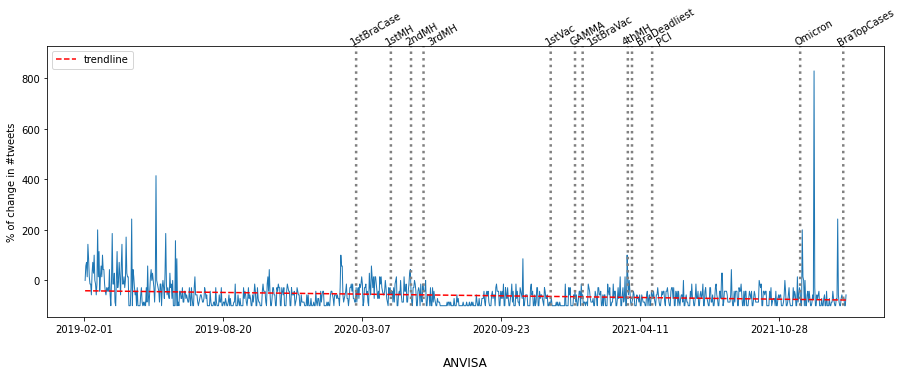

In [29]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def adjust_xticks(value):
    if value < 0:
      return ''
    start_date = agencies_df[agencies_df['order']==1]['date_created'][0]
    end_date = start_date + datetime.timedelta(days=value)
    label = str(end_date)
    return label


fig, ax = plt.subplots(figsize=(15,5))

# changes
x = agencies_df['order'].to_numpy()
y = agencies_df['change'].to_numpy()
x_new = np.linspace(x.min(), x.max(),len(agencies_df))
f = interp1d(x, y, kind='quadratic')
y_smooth=f(x_new)
ax.plot (x_new,y_smooth, linewidth=1.0)
ax.set_ylim(top=max(y_smooth)+100)
ax.set_ylabel('% of change in #tweets')

locs, labels = plt.xticks()
print(locs)
print(labels)
ax.set_xticklabels(np.array(list(map(adjust_xticks, locs))))

# baseline
##x_baseline = x
##y_baseline = [0]*len(x)
##line2 = ax.plot(x_baseline, y_baseline, '--', linewidth=0.5,
##                 label='baseline')

# trendline
z = np.polyfit(x.flatten(), y.flatten(), 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--", linewidth=1.5, label='trendline')

# marklines
lines = []
reference = 1000
for i, mark in enumerate(list_marks):
  x_covidline = [mark]*1100
  y_covidline = [i for i in range(-100,reference)]
  #x_covidline = [mark]*len(y_smooth)
  #y_covidline = y_smooth
  line = ax.plot(x_covidline, y_covidline, linestyle=':', linewidth=2.5,
                 #label=list_labels[i], 
                 color='gray')
  
  if i in [3, 6, 8, 9]:
    position_x = mark+4
    position_y = reference-70
  else:
    position_x = mark-10
    position_y = reference-70
  ax.annotate(list_labels[i], 
             (position_x, position_y), 
             color='black', rotation=30,
             size=10)
  
  lines.append(line)


ax.legend(loc='upper left',# bbox_to_anchor=(0.5, 1.15),
          ncol=1, fancybox=True)
plt.title('ANVISA', y=-0.2)